# NB05 &ndash; Spike detection

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Auxiliary-functions" data-toc-modified-id="Auxiliary-functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Auxiliary functions</a></span></li></ul></li><li><span><a href="#Box-filtering" data-toc-modified-id="Box-filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Box-filtering</a></span></li><li><span><a href="#Omniplex-filtering" data-toc-modified-id="Omniplex-filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Omniplex filtering</a></span></li></ul></div>

## Setup

In [1]:
%matplotlib inline

import ipywidgets as ipw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from facades import *
from matplotlib import rc
from scipy.fft import fft, ifft
from scipy.signal import bessel, fftconvolve, lfilter
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from typing import List, Tuple

In [2]:
rc('figure', figsize=(15, 4))

### Prepare data

In [3]:
recording_name = "grating-v206-he1800-hd2600"
channel = 29

In [4]:
recording = RecordingFacade.load(recording_name)
wb_source = recording.slow_channel(channel, SlowChannelType.WB)
spk_source = recording.spike_channel(channel)
signal_samples = wb_source.total_samples
signal_time = wb_source.total_time
sampling_rate = wb_source.sampling_rate

Getting spike channel 29


Memory-mapped arrays for original signal, its FFT, and the filtered version:

In [5]:
template_path = f'data/{recording_name}/slow_data/%s{channel:02d}%s.npy'
wb = np.memmap(template_path % ('wb', '_original'), dtype='f4', mode='r+')

### Auxiliary functions

In [6]:
def freq_sample(F):
    k = int(np.round(signal_samples * (F / sampling_rate)))
    return k

In [7]:
def time_sample(T):
    k = int(np.round(T * sampling_rate))
    return k

In [8]:
def plot_signal_decomposition(wb, lfp, spkc, seconds):
    samples = time_sample(seconds)
    
    x = np.linspace(0, seconds, samples)
    alpha = 0.9
    
    plt.figure(figsize=(15, 4))
    plt.plot(x, wb[:samples], alpha=alpha, label='Wideband (WB)')
    plt.plot(x, lfp[:samples], alpha=alpha, label='LFP')
    plt.plot(x, spkc[:samples], alpha=alpha, label='Spike-continuous (SPKC)')
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')

In [9]:
def detect_spikes(spkc, index, alignat='none'):
    spikes = []
    last_i = None
    for i in tqdm(index):
        if alignat == 'min':
            j = i + np.argmin(spkc[i:i+32])
        elif alignat == 'none':
            j = i
        else:
            raise ValueError(f'Unsupported alignment mode: {alignat}')
        if (j < 8) or (j > len(spkc) - 24):
            continue
        elif (last_i is None) or (j >= last_i + 32):
            spikes.append((j, spkc[j-8:j+24]))
            last_i = j
    return np.array(spikes, dtype=[('timestamp', 'u8'), ('waveform', '(32,)f4')])

In [10]:
def plot_wfs_summary(wfs, color, axes, threshold, title):
    mean = np.mean(wfs, axis=0)
    sdev = np.std(wfs, axis=0)
    x = 1e6 * np.arange(32) / sampling_rate
    axes.set_title(title)
    axes.fill_between(x, mean - 1 * sdev, mean + 1 * sdev, color=color, linewidth=0, alpha=0.75, label='$\mu \pm \sigma$')
    axes.fill_between(x, mean - 1 * sdev, mean - 2 * sdev, color=color, linewidth=0, alpha=0.5)
    axes.fill_between(x, mean + 1 * sdev, mean + 2 * sdev, color=color, linewidth=0, alpha=0.5, label='$\mu \pm 2\sigma$')
    axes.fill_between(x, mean - 2 * sdev, mean - 3 * sdev, color=color, linewidth=0, alpha=0.25)
    axes.fill_between(x, mean + 2 * sdev, mean + 3 * sdev, color=color, linewidth=0, alpha=0.25, label='$\mu \pm 3\sigma$')
    axes.axhline(threshold, color='black', label=fr'Threshold = {1e3 * threshold:.2f} $\mu$V')
    axes.plot(x, mean, color=color, label='$\mu$')
    axes.grid()
    axes.legend(loc='lower right')

In [11]:
def df_row(wfs, title):
    pca = PCA(3)
    pca.fit(spk_source.wfs)
    
    wfs_pca = pca.transform(wfs)
    mean_pca = np.mean(wfs_pca, axis=0)
    std_pca = np.std(wfs_pca, axis=0)
    
    return {
        'title': title,
        'count': len(wfs),
        'mean': np.mean(wfs),
        'std': np.std(wfs),
        'min': np.min(wfs),
        'max': np.max(wfs),
        'mean-pca1': mean_pca[0],
        'mean-pca2': mean_pca[1],
        'mean-pca3': mean_pca[2],
        'std-pca1': std_pca[0],
        'std-pca2': std_pca[1],
        'std-pca3': std_pca[2],
    }

## Box-filtering

In [12]:
def box_filter(radius):
    samples = 2 * time_sample(radius) + 1
    window = np.ones(samples) / samples
    return window

def filter_signal(signal, window):
    return fftconvolve(signal, window, mode='same')

In [13]:
radius = 0.0005

lfp = np.memmap(template_path % ('lfp', ''), dtype='f4', shape=(wb_source.total_samples), mode='w+')
spkc = np.memmap(template_path % ('spkc', ''), dtype='f4', shape=(wb_source.total_samples), mode='w+')

lfp[:] = filter_signal(wb, box_filter(radius))
spkc[:] = wb - lfp

In [14]:
plot_signal_decomposition(wb, lfp, spkc, seconds=0.05)
plt.title(f'{recording_name} (WB {channel}) with box filtering ({radius * 1000}ms)')
plt.legend();

The first and second order statistics of the spike-filtered signal are:

In [15]:
spk_mean = np.mean(spkc)
spk_sdev = np.std(spkc)

print(f'μ = {1e3 * spk_mean:.2f} mV, σ = {1e3 * spk_sdev:.2f} mV')

μ = -0.00 mV, σ = 8.18 mV


Let us detect spikes at multiple thresholds, each expressed as a number of standard deviations below the spike-filtered signal mean, that is, $\varepsilon = \mu - n \sigma$, $1 \leq n \leq 6$.

In [16]:
spk_at_dev = {
    n: detect_spikes(spkc, np.nonzero(spkc < spk_mean - n * spk_sdev)[0])
    for n in range(1, 7)
}
spk_mimic = detect_spikes(spkc, np.nonzero(spkc < spk_source.wf_threshold)[0])

In [17]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15), sharex=True, sharey=True)
axes = np.array(axes)

plot_wfs_summary(spk_source.wfs, color='C0', axes=axes[0, 0], threshold=spk_source.wf_threshold, title='PLX')
plot_wfs_summary(spk_mimic['waveform'], color='C6', axes=axes[0, 1], threshold=spk_source.wf_threshold, title=fr'Same as PLX')
for n, data in spk_at_dev.items():
    i, j = 1 + (n - 1) // 2, (n - 1) % 2
    plot_wfs_summary(data['waveform'], color=f'C{n}', axes=axes[i, j], threshold=spk_mean - n * spk_sdev, title=fr'{n} dev. below signal mean')

for ax in axes[len(axes)-1, :]:
    ax.set_xlabel('Time ($\mu$s)')
for ax in axes[:, 0]:
    ax.set_ylabel('Voltage (mV)')
fig.suptitle('Waveform summaries for different signal thresholds - box filtering');

Assume the threshold, $\varepsilon$, is expressed as $\varepsilon = \mu - n\sigma$.
The number of deviations below the signal mean, $n$ is given by the following expression:
$$n = \frac{\mu-\varepsilon}{\sigma}$$
Therefore, for the PLX file, $n$ is

In [18]:
(spk_mean - spk_source.wf_threshold) / spk_sdev

6.007051412263509

In [19]:
spikes_df = pd.DataFrame([
    df_row(spk_source.wfs, 'PLX'),
    df_row(spk_mimic['waveform'], 'Same thr. PLX'),
] + [
    df_row(data['waveform'], f'{n} sigma')
    for n, data in spk_at_dev.items()
])
spikes_df

title    count      mean       std       min       max  \
0            PLX    13653  0.000268  0.033150 -0.312500  0.298767   
1  Same thr. PLX    14551 -0.006316  0.033422 -0.252915  0.201681   
2        1 sigma  2502213 -0.000631  0.008475 -0.252915  0.201681   
3        2 sigma  1021114 -0.001248  0.010279 -0.252915  0.201681   
4        3 sigma   214809 -0.002042  0.014548 -0.252915  0.201681   
5        4 sigma    55042 -0.003431  0.021489 -0.252915  0.201681   
6        5 sigma    22747 -0.005195  0.028828 -0.252915  0.201681   
7        6 sigma    14590 -0.006309  0.033393 -0.252915  0.201681   

      mean-pca1     mean-pca2     mean-pca3  std-pca1  std-pca2  std-pca3  
0 -2.425027e-08 -2.648004e-08 -8.046605e-08  0.067550  0.055594  0.031246  
1  2.854120e-02  6.215100e-02  4.169674e-02  0.037121  0.061058  0.030991  
2  1.067474e-01 -2.917652e-02 -9.516552e-03  0.016132  0.019503  0.013573  
3  9.956677e-02 -2.754643e-02 -8.688120e-03  0.018216  0.023656  0.015635  
4  8.866171e-02 -1.949395e-02 -2.673310e-03  0.025040  0.037630  0.022215  
5  6.969762e-02  3.806534e-03  1.142952e-02  0.034203  0.057570  0.030769  
6  4.575226e-02  3.907827e-02  3.035635e-02  0.038229  0.065521  0.033152  
7  2.864507e-02  6.200870e-02  4.163328e-02  0.037139  0.061083  0.031003

## Omniplex filtering

In [20]:
def bessel_highpass_filter(data, lowcut, fs=sampling_rate, order=4):
    b, a = bessel(order, 2 * lowcut, btype='highpass', fs=fs)
    y = lfilter(b, a, data)
    return y

def bessel_lowpass_filter(data, highcut, fs=sampling_rate, order=4):
    b, a = bessel(order, 2 * highcut, btype='lowpass', fs=fs)
    y = lfilter(b, a, data)
    return y

spkc = np.memmap(template_path % ('spkc', ''), dtype='f4', shape=(wb_source.total_samples), mode='w+')
lfp = np.memmap(template_path % ('lfp', ''), dtype='f4', shape=(wb_source.total_samples), mode='w+')
lfp[:] = bessel_lowpass_filter(wb, 200)
spkc[:] = bessel_highpass_filter(wb, 300)

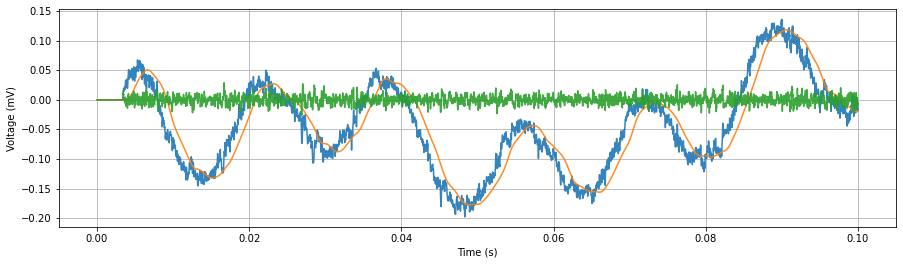

In [21]:
plot_signal_decomposition(wb, lfp, spkc, seconds=0.1)

In [22]:
spk_mean = np.mean(spkc)
spk_sdev = np.std(spkc)

In [23]:
spk_mean, spk_sdev

(5.537266e-15, 0.007242467)

In [24]:
spk_at_dev = {
    n: detect_spikes(spkc, np.nonzero(spkc < spk_mean - n * spk_sdev)[0])
    for n in range(1, 7)
}
spk_mimic = detect_spikes(spkc, np.nonzero(spkc < spk_source.wf_threshold)[0])

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15), sharex=True, sharey=True)
axes = np.array(axes)

plot_wfs_summary(spk_source.wfs, color='C0', axes=axes[0, 0], threshold=spk_source.wf_threshold, title='PLX')
plot_wfs_summary(spk_mimic['waveform'], color='C6', axes=axes[0, 1], threshold=spk_source.wf_threshold, title=fr'Same as PLX')
for n, data in spk_at_dev.items():
    i, j = 1 + (n-1) // 2, (n-1) % 2
    plot_wfs_summary(data['waveform'], color=f'C{n}', axes=axes[i, j], threshold=spk_mean - n * spk_sdev, title=fr'{n} dev. below signal mean')

for ax in axes[len(axes)-1, :]:
    ax.set_xlabel('Time ($\mu$s)')
for ax in axes[:, 0]:
    ax.set_ylabel('Voltage (mV)')
fig.suptitle('Waveform summaries for different signal thresholds - box filtering');

Assume the threshold, $\varepsilon$, is expressed as $\varepsilon = \mu - n\sigma$.
The number of deviations below the signal mean, $n$ is given by the following expression:
$$n = \frac{\mu-\varepsilon}{\sigma}$$
Therefore, for the PLX file, $n$ is

In [26]:
(spk_mean - spk_source.wf_threshold) / spk_sdev

6.788006413393251

In [27]:
spikes_df = pd.DataFrame([
    df_row(spk_source.wfs, 'PLX'),
    df_row(spk_mimic['waveform'], 'Same thr. PLX'),
] + [
    df_row(data['waveform'], f'{n} sigma')
    for n, data in spk_at_dev.items()
])
spikes_df

title    count      mean       std       min       max  \
0            PLX    13653  0.000268  0.033150 -0.312500  0.298767   
1  Same thr. PLX     6712  0.004843  0.030499 -0.339788  0.159105   
2        1 sigma  2610676 -0.000367  0.007391 -0.339788  0.159105   
3        2 sigma  1099152 -0.000640  0.008681 -0.339788  0.159105   
4        3 sigma   164794 -0.000472  0.012467 -0.339788  0.159105   
5        4 sigma    30289  0.001173  0.019984 -0.339788  0.159105   
6        5 sigma    13139  0.003518  0.025948 -0.339788  0.159105   
7        6 sigma     8904  0.004500  0.028806 -0.339788  0.159105   

      mean-pca1     mean-pca2     mean-pca3  std-pca1  std-pca2  std-pca3  
0 -2.257385e-08 -2.675890e-08 -8.198204e-08  0.067550  0.055594  0.031246  
1  5.602151e-02 -1.344282e-01  3.459081e-02  0.030969  0.029534  0.026464  
2  1.103276e-01 -3.390201e-02 -1.032162e-02  0.012581  0.014030  0.012431  
3  1.067712e-01 -3.735962e-02 -1.133186e-02  0.014712  0.016477  0.014070  
4  1.008862e-01 -4.684822e-02 -8.660243e-03  0.023725  0.025980  0.021742  
5  8.208108e-02 -7.319420e-02  7.154732e-03  0.036641  0.039880  0.033151  
6  6.344125e-02 -1.058562e-01  2.609250e-02  0.036821  0.037628  0.031779  
7  5.782082e-02 -1.242859e-01  3.283105e-02  0.033257  0.032187  0.028165